In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from abc import ABC, abstractmethod 

In [2]:
class ActivationFunction(Enum):
    ''' Enum of activation functions.
    '''
    Tanh = 0
    Sigmoid = 1
    Sin = 2
    Cos = 3
    Atan = 4

In [3]:
class ActivationFunctionNeuralNetwork(nn.Module):
    '''Activation function of the neural network.
    '''

    def __init__(self, activationFunction=ActivationFunction.Tanh):
        super(ActivationFunctionNeuralNetwork, self).__init__()
        self.activationFunction = activationFunction


    def forward(self, x):
        if self.activationFunction == ActivationFunction.Tanh:
            return torch.tanh(x)

        elif self.activationFunction == ActivationFunction.Sigmoid:
            return torch.sigmoid(x)

        elif self.activationFunction == ActivationFunction.Sin:
            return torch.sin(x)

        elif self.activationFunction == ActivationFunction.Cos:
            return torch.cos(x)

        elif self.activationFunction == ActivationFunction.Atan:
            return torch.atan(x)

In [4]:
class NeuralNet(nn.Module):
    ''' Neural Network used as a mapping function.
        Glorot initialisation.
    '''
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid):
        super(NeuralNet, self).__init__()
        self.layers = []
        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.layers.append(ActivationFunctionNeuralNetwork(activationFunction))

        self.layers.append(nn.Linear(in_features=layers[-2], out_features=layers[-1]))
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self._normalInit)

    def _normalInit(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)


    def partialDerivative(self, input, x, order=1):
        grad = self.model(input)
        for i in range(order):
            grad = torch.autograd.grad(outputs=grad, inputs=x, grad_outputs=torch.ones_like(grad), create_graph=True)[0]
        
        return grad


    @abstractmethod
    def training_loop(self, xBound, yBoundCondition, lossFunction, iterations, *xInt):
        pass


    def train(self, feedDict, lossFunction, iterations):
        # retrieve data
        xInt = torch.tensor(feedDict['xInt'], requires_grad=True).float()
        xBound = torch.tensor(feedDict['xBound'], requires_grad=True).float()
        yBoundCondition = torch.tensor(feedDict['yBoundCondition'])

        if 't' in feedDict:
            t = torch.tensor(feedDict["t"], requires_grad=True).float()
            self.training_loop(xBound, yBoundCondition, lossFunction, iterations, t, xInt)
        else:
            self.training_loop(xBound, yBoundCondition, lossFunction, iterations, xInt)


    def predict(self, feedDict):
        xInt = torch.tensor(feedDict['xInt']).float()
        xBound = torch.tensor(feedDict['xBound']).float()

        outputInt = self.model(xInt)
        outputBound = self.model(xBound)

        return outputInt, outputBound

In [5]:
class NeuralNetGradientDescent(NeuralNet):
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid, **parameters):
        super(NeuralNetGradientDescent, self).__init__(layers, activationFunction)
        self.lr = parameters.get("lr", 0.01)
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.lr)
        self.training_loss = []

    def training_loop(self, xBound, yBoundCondition, lossFunction, iterations, *xInt): 
        for epoch in range(iterations):
            yInt = self.model( torch.cat(xInt, 1) )
            yBound = self.model(xBound)
            loss = lossFunction(yInt, yBound, yBoundCondition, *xInt)
            self.training_loss.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if epoch % 1000 == 0:
                print('%d / %d, loss:%.2e' %(epoch, iterations, loss))

In [6]:
class NeuralNetNewtonMethod(NeuralNet):
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid, **parameters):
        super(NeuralNetNewtonMethod, self).__init__(layers, activationFunction)

        self.lr = parameters.get('lr', 1)
        self.max_iter = parameters.get('max_iter', 20)
        self.max_eval = parameters.get('max_eval', None)
        self.tolerance_grad = parameters.get('tolerance_grad', 1e-7)
        self.tolerance_change = parameters.get('tolerance_change', 1e-9)
        self.history_size = parameters.get('history_size', 100)
        self.line_search_fn = parameters.get('line_search_fn', None)

        self.optimizer = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=self.lr,
            max_iter=self.max_iter,
            max_eval=self.max_eval,
            tolerance_grad=self.tolerance_grad,
            tolerance_change=self.tolerance_change,
            history_size=self.history_size,
            line_search_fn=self.line_search_fn
            )
        self.training_loss = []
        
    def training_loop(self, xBound, yBoundCondition, lossFunction, iterations, *xInt):
        for epoch in range(iterations):
            def closure():
                if torch.is_grad_enabled():
                    self.optimizer.zero_grad()
                yInt = self.model(torch.cat(xInt, 1))
                yBound = self.model(xBound)
                loss = lossFunction(yInt, yBound, yBoundCondition, *xInt)
                self.training_loss.append(loss.item())
                if loss.requires_grad:
                    loss.backward()
                return loss
            self.optimizer.step(closure)
            if epoch % 1000 == 0:
                print('%d / %d' %(epoch, iterations))

In [7]:
class GenerateData():
    def __init__(self, domain, terminalCondition=False):
        ''' domain: list of tuples [(0, 1), (0, 1)]
        '''
        self.terminalCondition = terminalCondition
        self.timeDomain, self.spaceDomain = self._defineDomains(domain)
        self.boundaryDomainSize, self.totalBoundaryDomainSize = self._computeBoundaryDomainSize()

    def _defineDomains(self, domain):
        if self.terminalCondition:
            timeDomain = [domain[0]]
            spaceDomain = domain[1:]
        else:
            timeDomain = None
            spaceDomain = domain

        return timeDomain, spaceDomain


    def _computeBoundaryDomainSize(self):
        boundaryDomainSize = []
        totalBoundaryDomainSize = 0
        for i in range(len(self.spaceDomain)):
            boundaryDomainSize.append(1)
            for j in range(len(self.spaceDomain)):
                if j != i:
                    boundaryDomainSize[i] = boundaryDomainSize[i] * (self.spaceDomain[j][1] - self.spaceDomain[j][0])
            totalBoundaryDomainSize = totalBoundaryDomainSize + 2 * boundaryDomainSize[i]
        
        return boundaryDomainSize, totalBoundaryDomainSize


    def sampleInteriorX(self, pointCount):
        ''' If time involved, it is treated as an extra dimension: no change for interior sampling.
        '''

        if not self.timeDomain is None:
            domain = self.timeDomain + self.spaceDomain
        else:
            domain = self.spaceDomain

        xInt = []
        for i in range(len(domain)):
            xInt.append(np.random.uniform(low=domain[i][0], high=domain[i][1], size=(pointCount, 1)))
        
        return xInt

    def sampleBoundaryX(self, pointCount):
        ''' If there is a terminal condition, xBound is composed of interior points with the first component being the final time T.
            If there is no, the sampling is done on the boundaries of the space domain.
        '''
        if not self.timeDomain is None:
            xBound = self.sampleInteriorX(pointCount)

            # time component
            T = self.timeDomain[0][1]
            xBound[0] = T * np.ones_like(xBound[1])

        else:
            xBound = self._sampleBoundaryX(pointCount)

        return xBound


    def _sampleBoundaryX(self, pointCount):
        ''' Sample points on the boundaries of the space domain only.
        '''
        if pointCount < 2 * len(self.spaceDomain):
            pointCount = 2 * len(self.spaceDomain)

        xBound = []

        # iterate over dimensions
        for i in range(len(self.spaceDomain)):
            xBound.append(np.empty((0, 1), dtype=np.float64))

            # iterate over boundaries
            for j in range(len(self.spaceDomain)):
                for bound in self.spaceDomain[j]:
                    newPoints = max(int(pointCount * self.boundaryDomainSize[j] / self.totalBoundaryDomainSize), 1)
                    if j == i:
                        newX = np.full((newPoints, 1), bound, dtype=np.float64)
                    else:
                        newX = np.random.uniform(low=self.spaceDomain[j][0], high=self.spaceDomain[j][1], size=(newPoints, 1))
                    xBound[i] = np.concatenate((xBound[i], newX))

        return xBound

In [8]:
class PDENeuralNetwork():
    def __init__(self, network, domain, terminalCondition):
        self.network = network
        self.domain = domain
        self.terminalCondition = terminalCondition
        self.data = GenerateData(domain=self.domain, terminalCondition=self.terminalCondition)


    def sampleData(self, interiorPointCount, boundaryPointCount):
        feedDict = {}

        interiorSample = self.data.sampleInteriorX(interiorPointCount)
        if self.terminalCondition:
            t, xInt = interiorSample[0], interiorSample[1:]
            feedDict['t'] = np.array(t)
        else:
            xInt = interiorSample

        xBound = self.data.sampleBoundaryX(boundaryPointCount)
        yBoundCondition= self.boundaryCondition(xBound)

        feedDict['xInt'] = np.array(xInt)[:,:,0].T
        feedDict['xBound'] = np.array(xBound)[:,:,0].T
        feedDict['yBoundCondition'] = np.array(yBoundCondition)

        return feedDict


    def train(self, interiorPointCount, boundaryPointCount, lossWeight, iterations):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        self.network.train(feedDict, self.defaultLoss, iterations)


    def predict(self, interiorPointCount, boundaryPointCount, lossWeight):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        predictionInterior, predictionBound = self.network.predict(feedDict)

        # Analytical Solution
        self.analyticalInterior = self.analyticalSolution(feedDict['xInt'])
        self.analyticalBound = self.analyticalSolution(feedDict['xBound'])

        # Compute L2 error (not sure the sum of interior and boundary is what we need...)
        errorInt = np.sqrt(np.sum((self.analyticalInterior - predictionInterior.detach().numpy()) ** 2))
        errorBound = np.sqrt(np.sum((self.analyticalBound - predictionBound.detach().numpy()) ** 2))

        return errorInt + errorBound


    def defaultLoss(self, yInt, yBound, yBoundCondition, *xInt):
        # put that in the parent class
        lossInt, lossBound = self.computeLossTerms(self.domain, yInt, yBound, yBoundCondition, *xInt)

        return self.lossWeight * lossInt + (1 - self.lossWeight) * lossBound

    @abstractmethod
    def computeLossTerms(self, domain, yInt, yBound, yBoundCondition, *xInt):
        pass

In [9]:
class HamiltonJacobiBellman(PDENeuralNetwork):
    def __init__(self, network, domain, beta=1):
        PDENeuralNetwork.__init__(self, network=network, domain=domain, terminalCondition=True)
        self.beta = beta
        self.T = domain[0][1]

    def computeLossTerms(self, domain, yInt, yBound, yBoundCondition, t, xInt):
        input = torch.cat([t, xInt], 1)
        derivativeTime = network.partialDerivative(input=input, x=t, order=1)
        derivativeSpace = network.partialDerivative(input=input, x=xInt, order=1)

        equation = (
            derivativeTime 
            - 1 / (2 * self.beta) * torch.einsum('ni,nij,njk,nk->n', derivativeSpace, self.g(xInt), self.g(xInt), derivativeSpace).reshape(-1,1)
            + torch.einsum('ij,ij->i', derivativeSpace, self.f(xInt) ).reshape(-1,1)
            + self.l(xInt).reshape(-1,1)
            )

        lossInt = torch.mean(torch.square(equation))
        lossBound = torch.mean(torch.square(yBound - yBoundCondition))

        return lossInt, lossBound


    @abstractmethod
    def f(self, x):
        pass


    @abstractmethod    
    def g(self, x):
        pass


    @abstractmethod
    def l(self, x):
        pass

In [10]:
class VanDerPolOscillator(HamiltonJacobiBellman):
    def __init__(self, lossWeight, network=None):
        domain = [(0, 1), (-1, 1), (-1, 1)]
        HamiltonJacobiBellman.__init__(self, network=network, domain=domain,)
        self.lossWeight = lossWeight

    def f(self, x):
        x1 = x[:, 0].reshape(-1,1)
        x2 = x[:, 1].reshape(-1,1)
        return torch.cat([x2, -x1 + x2 * (1 - x1**2)], 1)

    def g(self, x):
        n = x.shape[0]
        return torch.stack(n * [torch.eye(2)])

    def l(self, x):
        return torch.norm(x, dim=1)
        
    def boundaryCondition(self, x):
        return 0

In [11]:
class LaplaceBase(PDENeuralNetwork):
    def __init__(self, network, domain, terminalCondition=False):
        PDENeuralNetwork.__init__(self, domain=domain, network=network, terminalCondition=terminalCondition)


    def computeLossTerms(self, domain, yInt, yBound, yBoundCondition, xInt):
        gradients = network.partialDerivative(input=xInt, x=xInt, order=2)
        lossInt = torch.mean(torch.square(gradients))
        lossBound = torch.mean(torch.square(yBound - yBoundCondition))

        return lossInt, lossBound

    @abstractmethod
    def boundaryCondition(self, x):
        pass

In [12]:
class Laplace_2d(LaplaceBase):
    def __init__(self, frequency, lossWeight, network=None):
        domain = [(0, 1), (0, 1)]
        LaplaceBase.__init__(self, network=network, domain=domain)
        self.frequency = frequency
        self.lossWeight = lossWeight


    def analyticalSolution(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)


    def boundaryCondition(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)

# Van der Pol oscillator example

In [13]:
interiorPointCount = 100
boundaryPointCount = 100
lossWeight = 0.5
iterations = 3000

In [14]:
network = NeuralNetGradientDescent([3, 10, 1], ActivationFunction.Sigmoid, **{'lr': 0.01})
vanDerPol = VanDerPolOscillator(lossWeight=lossWeight, network=network)

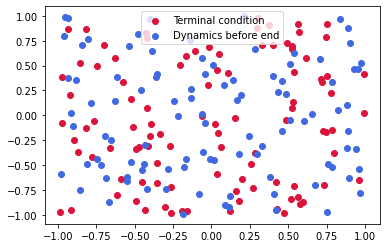

In [15]:
data = vanDerPol.sampleData(interiorPointCount, boundaryPointCount)
xInt = torch.from_numpy(data['xInt']).float()
xBound = torch.from_numpy(data['xBound']).float()
plt.scatter( xBound[:,1], xBound[:,2], color='crimson', label='Terminal condition' )
plt.scatter( xInt[:,0], xInt[:,1], color='royalblue', label='Dynamics before end' )
plt.legend();

In [16]:
vanDerPol.train(interiorPointCount, boundaryPointCount, lossWeight, iterations)

0 / 3000, loss:8.71e-01
1000 / 3000, loss:3.24e-02
2000 / 3000, loss:1.10e-02


# Laplace example

In [17]:
interiorPointCount = 100
boundaryPointCount = 100
lossWeight = 0.0001
iterations = 3000
frequency = 2 * np.pi

In [18]:
network = NeuralNetGradientDescent([2, 10, 1], ActivationFunction.Sigmoid, **{'lr': 0.01})
laplace = Laplace_2d(frequency=frequency, lossWeight=lossWeight, network=network)

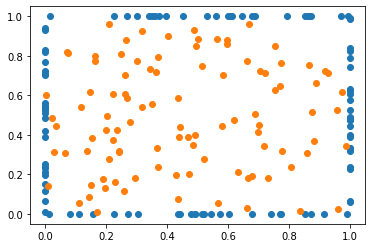

In [19]:
data = laplace.sampleData(interiorPointCount, boundaryPointCount)
xInt = torch.from_numpy(data['xInt']).float()
xBound = torch.from_numpy(data['xBound']).float()
plt.scatter( xBound[:,0], xBound[:,1] )
plt.scatter( xInt[:,0], xInt[:,1] );

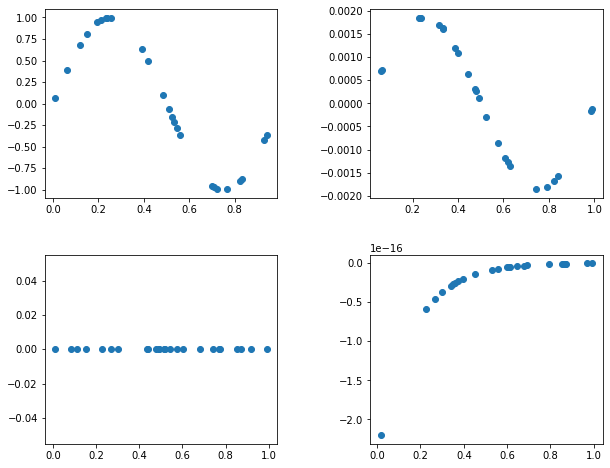

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.flatten()
for ax, idx, coord in zip(axs, range(4), [1,1,0,0]):
    ax.scatter( data['xBound'][idx*25 : (idx+1)*25, coord], data['yBoundCondition'][idx*25 : (idx+1)*25] )
plt.subplots_adjust(wspace=0.4, hspace=0.3);

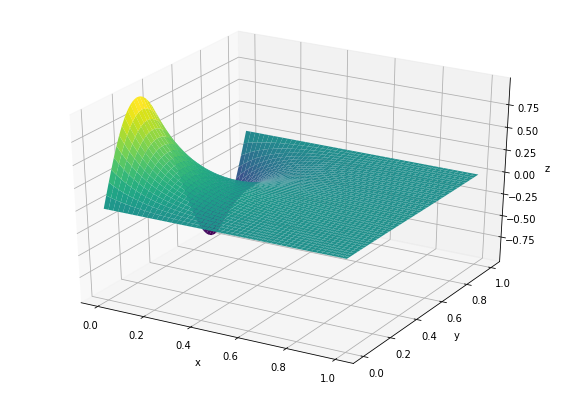

In [21]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.analyticalSolution([X, Y])

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Adam optimizer

In [22]:
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations)

0 / 3000, loss:2.19e-01
1000 / 3000, loss:6.98e-02
2000 / 3000, loss:3.42e-02


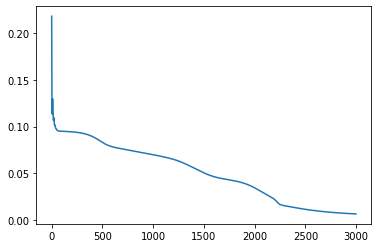

In [23]:
plt.plot( laplace.network.training_loss );

In [24]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

10.095545196086338

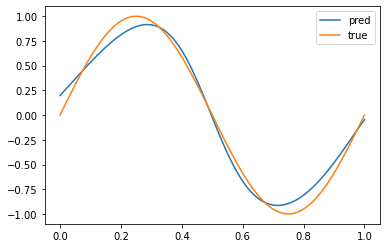

In [25]:
x0 = 0
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([x0 * np.ones(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([x0 * np.ones(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

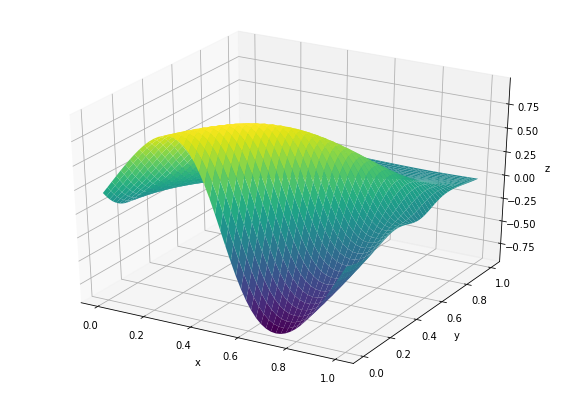

In [26]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.network.model(torch.tensor([X, Y]).T.float()).detach().numpy()[:,:,0]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

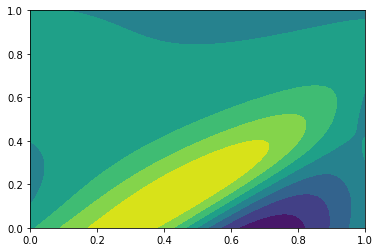

In [27]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z);

In [28]:
# can we plot the error?

## LBFGS optimizer

In [37]:
network = NeuralNetNewtonMethod([2, 10, 1], ActivationFunction.Sigmoid, **{'max_iter': 40})
laplace = Laplace_2d(frequency=frequency, lossWeight=lossWeight, network=network)
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations=10)

0 / 10


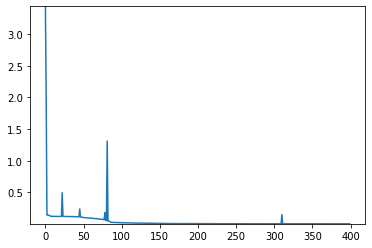

In [38]:
plt.plot( laplace.network.training_loss );
plt.ylim( laplace.network.training_loss[-1], laplace.network.training_loss[0]);

In [39]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

9.440445538914496

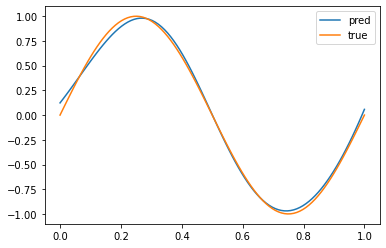

In [40]:
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

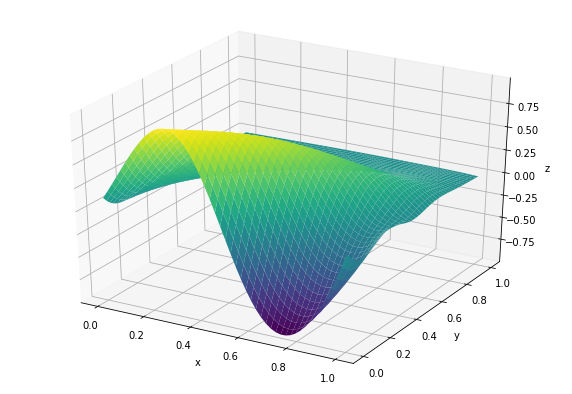

In [41]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.network.model(torch.tensor([X, Y]).T.float()).detach().numpy()[:,:,0]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

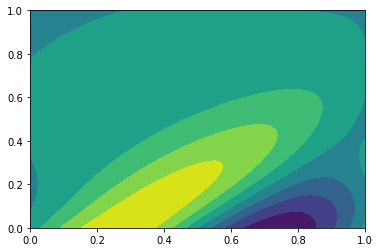

In [42]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z);